<a href="https://colab.research.google.com/github/annulet/CNN_NVIDIA/blob/master/hw_6_face_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Обучить сиамскую сеть для верификации лиц на датасете LFW
Библиотеки: [Python, Tensorflow]

In [0]:
%tensorflow_version 2.x

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

##Загрузка датасета LFW

In [0]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

Label: b'Tom_Amstutz'


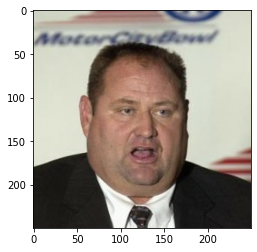

In [5]:
for example in train_ds.take(1):  # Only take a single example
    image, label = example[1], example[0]

    plt.imshow(image.numpy().astype(np.float32)/255)
    print(f"Label: {label}")

In [6]:
train_ds

<DatasetV1Adapter shapes: ((), (250, 250, 3)), types: (tf.string, tf.uint8)>

##Создание модели CNN

In [0]:
EMB_SIZE = 250

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

##Contrastive Loss

In [0]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

##Подготовка пайплайна данных

In [0]:
def normalize_example(label, image):
    return label, tf.cast(image, tf.float32) / 255.

In [0]:
BATCH_SIZE = 64
NUM_EPOCHS = 10

train_ds = train_ds.map(normalize_example)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [23]:
train_ds

<DatasetV1Adapter shapes: ((None,), (None, 250, 250, 3)), types: (tf.string, tf.float32)>

In [0]:
test_ds = test_ds.map(normalize_example)
test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.batch(BATCH_SIZE)

In [27]:
test_ds

<DatasetV1Adapter shapes: ((None,), (None, 250, 250, 3)), types: (tf.string, tf.float32)>

##Подготовка к обучению

In [0]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

##Обучение модели

In [13]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 95.50837707519531
[200] Loss: 0.0
[400] Loss: 0.030790502205491066
[600] Loss: 9.481263160705566
[800] Loss: 0.008863966912031174
[1000] Loss: 0.0
[1200] Loss: 0.0
[1400] Loss: 0.0
[1600] Loss: 0.0
[1800] Loss: 0.16380345821380615
CPU times: user 9min 27s, sys: 5min 7s, total: 14min 35s
Wall time: 18min 21s


##Получение эмбеддингов для тестовой выборки

In [31]:
%%time

test_embs = []
for iteration, (labels, images) in enumerate(test_ds):
    embs = model(images)
    label = labels
    test_embs.append((embs, label))

CPU times: user 3.46 s, sys: 1.53 s, total: 5 s
Wall time: 4.21 s
